# Language modeling using transformer on Hermann Hesse bibliography data (in Russian)

### Based on course ["Нейронные сети и обработка текста"](https://stepik.org/course/54098/)

If you are going to read this notebook, I recommend you to open it in [google colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true) and start reading from [the beginning of the analysis](#scrollTo=fxTodB_qpyEX), using the attached hyperlinks on functions and classes if you need to.

## Required libraries, functions and classes:

In [ ]:
!pip3 install pytorch-nlp --quiet
!pip3 install youtokentome --quiet
!pip3 install livelossplot --quiet

In [3]:
from google.colab import drive
from google.colab import files

import sys

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn import functional as F
from torchnlp.word_to_vector import BPEmb

import youtokentome as yttm

import random

import heapq

from livelossplot import PlotLosses

from tqdm.notebook import tqdm

import datetime

from traceback import format_exc

from copy import deepcopy

In [4]:
def init_random_seed(value=0):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    torch.backends.cudnn.deterministic = True

init_random_seed()

In [5]:
def copy_data_to_device(data, device):
    if torch.is_tensor(data):
        return data.to(device)
    elif isinstance(data, (list, tuple)):
        return [copy_data_to_device(elem, device) for elem in data]
    raise ValueError('Invalid data type {}'.format(type(data)))

In [6]:
def get_params_number(model):
    return sum(t.numel() for t in model.parameters())

In [7]:
def divisors(n):
    """Find all divisors of a number"""
    i = 1
    divisors = []
    while i <= n**0.5:
        if (n % i == 0) : 
            if (n / i == i):
                divisors.append(i)
            else:
                divisors.extend([i, n // i])
        i = i + 1
    return sorted(divisors)

In [8]:
def split_into_chunks(filename, chunk_size=200):
    with open(filename) as f:
        full_text = f.read()
    return [full_text[start:start + chunk_size] for start in range(0, len(full_text), chunk_size // 2)]

In [9]:
def ensure_length(txt, out_len, pad_value):
    if len(txt) < out_len:
        txt = list(txt) + [pad_value] * (out_len - len(txt))
    else:
        txt = txt[:out_len]
    return txt

class LanguageModelDataset(Dataset):
    def __init__(self, sample, chunk_length=100, pad_value=0):
        self.sample = sample
        self.chunk_length = chunk_length
        self.pad_value = pad_value

    def __len__(self):
        return len(self.sample)

    def __getitem__(self, item):
        text = self.sample[item]
        start_i = random.randint(0, max(0, len(text) - self.chunk_length - 1))
        chunk = text[start_i : start_i + self.chunk_length + 1]

        seed_part = chunk[:-1]
        target_part = chunk[1:]

        seed_part = ensure_length(seed_part, self.chunk_length, self.pad_value)
        target_part = ensure_length(target_part, self.chunk_length, self.pad_value)

        seed_part = np.array(seed_part)
        target_part = np.array(target_part)

        return seed_part, target_part

In [10]:
def make_target_dependency_mask(length):
    full_mask = torch.ones(length, length)
    ignore_mask = torch.tril(full_mask) < 1
    full_mask.masked_fill_(ignore_mask, float('-inf'))
    full_mask.masked_fill_(~ignore_mask, 0)
    return full_mask

In [11]:
def make_positional_encoding(max_length, embedding_size):
    time = np.pi * torch.arange(0, max_length).float()
    freq_dividers = torch.arange(1, embedding_size // 2 + 1).float()
    inputs = time[:, None] / freq_dividers[None, :]
    result = torch.zeros(max_length, embedding_size)
    result[:, 0::2] = torch.sin(inputs)
    result[:, 1::2] = torch.cos(inputs)
    return result

In [12]:
class LanguageModel(nn.Module):
    """ General class. param::backbone - used architecture of NNet """
    def __init__(self, vocab_size, emb_size, backbone, emb_weights=None, freeze=True, emb_dropout=0.0):
        super().__init__()
        if emb_weights is not None:
            self.embeddings = nn.Embedding.from_pretrained(emb_weights, freeze=freeze, padding_idx=0)
        else:
            self.embeddings = nn.Embedding(vocab_size, emb_size, padding_idx=0)
        self.embedding_size = emb_size
        self.emb_dropout = nn.Dropout(emb_dropout)
        self.backbone = backbone
        self.out = nn.Linear(emb_size, vocab_size)
    
    def forward(self, seed_tokenized_sample):
        batch_size, max_in_length = seed_tokenized_sample.shape

        seed_padding_mask = seed_tokenized_sample == 0
        dependency_mask = make_target_dependency_mask(max_in_length).to(seed_tokenized_sample.device)
        
        seed_embs = self.embeddings(seed_tokenized_sample)  # BatchSize x MaxInLen x EmbSize
        pos_codes = make_positional_encoding(max_in_length, self.embedding_size).unsqueeze(0).to(seed_embs.device) # 1 x MaxInLen x EmbSize
        seed_embs = seed_embs + pos_codes
        seed_embs = self.emb_dropout(seed_embs)

        # BatchSize x TargetLen x EmbSize
        target_features = self.backbone(seed_embs,
                                        mask=dependency_mask,
                                        src_key_padding_mask=seed_padding_mask)
        logits = self.out(target_features)  # BatchSize x TargetLen x VocabSize
        return logits

In [13]:
def lm_cross_entropy(pred, target):
    """
    pred - BatchSize x TargetLen x VocabSize
    target - BatchSize x TargetLen
    """
    pred_flat = pred.view(-1, pred.shape[-1])  # BatchSize*TargetLen x VocabSize
    target_flat = target.view(-1)  # BatchSize*TargetLen
    return F.cross_entropy(pred_flat, target_flat, ignore_index=0)

In [14]:
class BatchFirstTransformerEncoder(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.impl = nn.TransformerEncoder(*args, **kwargs)
        self.initialize_weights()
    
    def forward(self, src, *args, **kwargs):
        src = src.transpose(0, 1).contiguous()  # MaxInLen x BatchSize x EmbSize
        result = self.impl(src, *args, **kwargs)  # TargetLen x BatchSize x EmbSize
        result = result.transpose(0, 1).contiguous()  # BatchSize x TargetLen x EmbSize
        return result
    
    def initialize_weights(self):
        for param in self.impl.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

In [15]:
def train_eval_loop(model, train_dataset, val_dataset, criterion, lr=1e-3, epoch_n=100, batch_size_train=32,
                    batch_size_val=32, device=None, early_stopping_patience=10, l2_reg_alpha=0, data_loader_ctor=DataLoader,
                    optimizer_ctor=None, lr_scheduler_ctor=None, dataloader_workers_n=0, draw_loss=False, show_bar=False, show_lr=False):


    assert len(train_dataset) % batch_size_train == 0, "len of train_dataset must be divisible by train_batch_size"
    assert len(val_dataset) % batch_size_val == 0, "len of val_dataset must be divisible by val_batch_size"

    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    device = torch.device(device)
    model.to(device)

    if optimizer_ctor is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg_alpha)
    else:
        optimizer = optimizer_ctor(model.parameters(), lr=lr)
    
    if lr_scheduler_ctor is not None:
        lr_scheduler = lr_scheduler_ctor(optimizer)
    else:
        lr_scheduler = None

    if draw_loss:
        liveplot = PlotLosses()
    
    train_dataloader = data_loader_ctor(train_dataset, batch_size=batch_size_train, num_workers=dataloader_workers_n)
    val_dataloader = data_loader_ctor(val_dataset, batch_size=batch_size_val, num_workers=dataloader_workers_n)

    best_val_loss = float("inf")
    best_epoch_i = 0
    best_model = deepcopy(model)
    
    for epoch_i in range(epoch_n):
        try:
            if not draw_loss:
                epoch_start = datetime.datetime.now()
                print(f"Epoch {epoch_i}")

            model.train()
            mean_train_loss = 0
            train_batches_n = 0

            for batch_i, (batch_x, batch_y) in enumerate(tqdm(train_dataloader)) if show_bar else enumerate(train_dataloader):
                batch_x = copy_data_to_device(batch_x, device)
                batch_y = copy_data_to_device(batch_y, device)

                pred = model(batch_x)
                loss = criterion(pred, batch_y)

                model.zero_grad()
                loss.backward()

                optimizer.step()

                mean_train_loss += float(loss)
                train_batches_n += 1


            mean_train_loss /= train_batches_n

            model.eval()
            mean_val_loss = 0
            val_batches_n = 0

            with torch.no_grad():
                for batch_i, (batch_x, batch_y) in enumerate(val_dataloader):

                    batch_x = copy_data_to_device(batch_x, device)
                    batch_y = copy_data_to_device(batch_y, device)

                    pred = model(batch_x)
                    loss = criterion(pred, batch_y)

                    mean_val_loss += float(loss)
                    val_batches_n += 1

            mean_val_loss /= val_batches_n

            if not draw_loss:
                print('{} iterations for training and {} for validation, {:0.2f} sec'.format(train_batches_n, val_batches_n,
                                                           (datetime.datetime.now() - epoch_start).total_seconds()))
                print('Average value of the train loss function:', mean_train_loss)
                print('Average value of the validation loss function:', mean_val_loss)
            else:
                liveplot.update({'mean loss': mean_train_loss, "val_mean loss": mean_val_loss})
                liveplot.draw()

            if mean_val_loss < best_val_loss:
                best_epoch_i = epoch_i
                best_val_loss = mean_val_loss
                best_model = deepcopy(model)
                if not draw_loss:
                    print('New best model!')
            elif epoch_i - best_epoch_i > early_stopping_patience:
                print('The model has not improved over the last {} epochs, stop training'.format(
                    early_stopping_patience))
                break
  
            if lr_scheduler is not None:
                if isinstance(lr_scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    lr_scheduler.step(mean_val_loss)
                elif isinstance(lr_scheduler, torch.optim.lr_scheduler.StepLR):
                    lr_scheduler.step()
                    if show_lr:
                        print(optimizer.param_groups[0]['lr'])
                else:
                    lr_scheduler.step()

            print()
        except KeyboardInterrupt:
            print('Stopped early by user')
            break
        except Exception as ex:
            print('Error while training: {}\n{}'.format(ex, format_exc()))
            break

    return best_val_loss, best_model

In [16]:
class GreedyGenerator:
    def __init__(self, model, tokenizer, device='cuda', eos_token_id=3):
        self.model = model
        self.tokenizer = tokenizer
        self.device = torch.device(device)
        self.model.to(self.device)
        self.eos_token_id = eos_token_id

    def __call__(self, seed_text, max_steps_n=40):
        seed_tokens = self.tokenizer.encode([seed_text])[0]

        for _ in range(max_steps_n):
            in_batch = torch.tensor(seed_tokens).unsqueeze(0).to(self.device)
            best_next_token = self.model(in_batch)[0, -1].argmax()
            if best_next_token == self.eos_token_id:
                break

            seed_tokens.append(best_next_token)

        return self.tokenizer.decode([seed_tokens])[0]

In [17]:
class BeamGenerator:
    def __init__(self, model, tokenizer, device='cuda', eos_token_id=3):
        self.model = model
        self.tokenizer = tokenizer
        self.device = torch.device(device)
        self.model.to(self.device)
        self.eos_token_id = eos_token_id

    def __call__(self, seed_text, max_steps_n=40, return_hypotheses_n=5, beamsize=5):
        seed_tokens = self.tokenizer.encode([seed_text])[0]
        initial_length = len(seed_tokens)

        partial_hypotheses = [(0, seed_tokens)]
        final_hypotheses = []

        while len(partial_hypotheses) > 0:
            cur_partial_score, cur_partial_hypothesis = heapq.heappop(partial_hypotheses)

            in_batch = torch.tensor(cur_partial_hypothesis).unsqueeze(0).to(self.device)
            next_tokens_logits = self.model(in_batch)[0, -1]
            next_tokens_logproba = F.log_softmax(next_tokens_logits, dim=0)
            topk_continuations = next_tokens_logproba.topk(beamsize)

            for token_score, token_idx in zip(topk_continuations.values, topk_continuations.indices):
                token_score = float(token_score)
                token_idx = int(token_idx)

                old_denorm_score = cur_partial_score * np.sqrt(len(cur_partial_hypothesis))
                new_score = (old_denorm_score - token_score) / np.sqrt(len(cur_partial_hypothesis) + 1)

                new_hypothesis = cur_partial_hypothesis + [token_idx]
                new_item = (new_score, new_hypothesis)

                if token_idx == self.eos_token_id or len(new_hypothesis) - initial_length >= max_steps_n:
                    final_hypotheses.append(new_item)
                else:
                    heapq.heappush(partial_hypotheses, new_item)

            if len(partial_hypotheses) > beamsize:
                partial_hypotheses = heapq.nsmallest(beamsize, partial_hypotheses)
                heapq.heapify(partial_hypotheses)

        final_scores, final_token_lists = zip(*final_hypotheses)
        final_texts = self.tokenizer.decode(list(final_token_lists))

        result = list(zip(final_scores, final_texts))
        result.sort()
        result = result[:return_hypotheses_n]

        return result

In [18]:
class ProbGenerator:
    def __init__(self, model, tokenizer, device='cuda', eos_token_id=3, max_steps_n=40, temperature=1.0):
        self.model = model
        self.tokenizer = tokenizer
        self.device = torch.device(device)
        self.model.to(self.device)
        self.eos_token_id = eos_token_id
        self.max_steps_n = max_steps_n
        self.temperature = temperature

    def __call__(self, seed_text):
        seed_tokens = self.tokenizer.encode([seed_text])[0]
        
        with torch.no_grad():
            for _ in range(self.max_steps_n):
                in_batch = torch.tensor(seed_tokens).unsqueeze(0).to(self.device)
                logits_next = self.model(in_batch)[0, -1]
                p_next = F.softmax(logits_next / self.temperature, dim=-1).data.cpu().numpy()
                next_token = np.random.choice(len(tokenizer.vocab()), p=p_next)
                if next_token == self.eos_token_id:
                    break
                seed_tokens.append(next_token)

        return ''.join(self.tokenizer.decode([seed_tokens], ignore_ids=[0,2,3]))

## Loading dataset and splitting it into training and test samples:

In [19]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [20]:
dataset_filename = "/content/gdrive/My Drive/ML/datasets/Hermann_Hesse_bibliography_ru.txt"
all_chunks = split_into_chunks(dataset_filename, chunk_size=500)
len(all_chunks)

17067

In [21]:
np.random.shuffle(all_chunks)

TRAIN_SPLIT = int(len(all_chunks) * 0.7)
train_sample = all_chunks[:TRAIN_SPLIT]
val_sample = all_chunks[TRAIN_SPLIT:]

print("Training sample size:", len(train_sample))
print("Validation sample size:", len(val_sample))

# Save train sample in file for further BPE training:
TRAIN_SAMPLE_FILENAME = "/tmp/train_sample.txt"

with open(TRAIN_SAMPLE_FILENAME, 'w') as f:
    f.write('\n'.join(train_sample))


Training sample size: 11946
Validation sample size: 5121


##  BPE tokenization using [youtokentome library](https://pypi.org/project/youtokentome/):

In [22]:
NUM_TOKENS_BPE = 500
BPE_MODEL_FILENAME = "/tmp/bpe_model.yttm"
yttm.BPE.train(data=TRAIN_SAMPLE_FILENAME, vocab_size=NUM_TOKENS_BPE, model=BPE_MODEL_FILENAME)

tokenizer = yttm.BPE(BPE_MODEL_FILENAME)

train_tokenized_sample = tokenizer.encode(train_sample, bos=True, eos=True)
val_tokenized_sample = tokenizer.encode(val_sample, bos=True, eos=True)

In [23]:
print(train_tokenized_sample[0])

[2, 4, 12, 18, 212, 326, 346, 12, 150, 157, 192, 18, 267, 150, 239, 297, 25, 159, 333, 195, 29, 214, 28, 152, 229, 245, 174, 326, 240, 13, 23, 18, 195, 29, 214, 28, 209, 332, 350, 334, 193, 174, 156, 191, 14, 324, 15, 195, 29, 214, 28, 31, 4, 93, 414, 407, 278, 380, 27, 355, 155, 410, 231, 403, 244, 18, 305, 422, 6, 169, 160, 259, 440, 152, 227, 194, 219, 465, 164, 29, 319, 211, 193, 175, 372, 20, 443, 165, 233, 470, 437, 247, 33, 155, 343, 175, 9, 293, 396, 407, 33, 31, 282, 18, 255, 264, 18, 274, 16, 164, 11, 408, 417, 357, 200, 18, 315, 191, 155, 4, 64, 5, 164, 18, 224, 211, 197, 161, 212, 381, 332, 326, 346, 12, 296, 174, 374, 157, 420, 154, 18, 296, 174, 156, 496, 380, 186, 35, 18, 296, 174, 156, 496, 165, 319, 54, 385, 166, 294, 12, 18, 209, 212, 333, 372, 20, 443, 176, 194, 150, 190, 13, 185, 246, 151, 22, 12, 200, 15, 4, 33, 9, 35, 5, 246, 387, 28, 337, 4, 14, 23, 21, 157, 180, 158, 172, 202, 304, 203, 259, 204, 152, 164, 226, 15, 326, 25, 215, 18, 166, 294, 12, 18, 209, 372, 2

In [24]:
print(tokenizer.vocab())

['<PAD>', '<UNK>', '<BOS>', '<EOS>', '▁', 'о', 'е', 'а', 'и', 'н', 'т', 'с', 'л', 'в', 'р', 'м', 'к', 'д', ',', 'у', 'п', 'я', 'ы', 'ь', 'г', 'б', 'з', 'ч', 'й', 'ж', 'х', '.', 'ш', 'ю', 'щ', 'ц', 'э', '—', '\xa0', '-', 'Н', 'О', 'В', 'К', 'ф', 'П', 'И', 'Т', '?', 'С', 'Г', 'М', ':', 'Я', '!', '–', 'Д', ';', 'Б', 'А', '«', '»', 'Э', 'Е', 'Л', 'Р', 'З', 'Ч', 'У', '1', 'ъ', '(', ')', ']', '[', 'Ф', 'Х', 'i', 'e', '8', 'a', 's', 'u', '9', 'Ш', '…', 'r', 'o', '7', 't', '2', '4', '6', 'Ж', '3', '0', '5', 'Ц', 'n', 'm', 'I', 'l', 'c', 'Ю', 'X', 'd', 'ё', 'g', 'V', 'v', 'p', 'h', 'b', 'L', '“', '„', 'f', 'C', 'Й', 'q', 'Ь', 'x', "'", 'M', 'A', 'Ы', 'E', 'T', 'D', 'B', 'y', 'P', 'J', '’', 'Щ', 'S', 'F', 'w', 'k', 'R', 'z', 'U', 'N', 'K', 'H', 'j', 'Q', '№', 'W', 'G', '▁с', '▁п', '▁в', '▁н', 'то', '▁и', '▁о', 'но', 'ст', 'ен', 'ко', 'го', 'ал', '▁м', 'ра', '▁д', '▁по', '▁б', 'ро', '▁не', 'ка', 'ел', 'ре', '▁на', 'ть', 'ли', '▁т', 'во', '▁ч', 'ни', '▁у', 'ри', '▁е', '▁з', 'ло', 'ны', 'ся', 'ер',

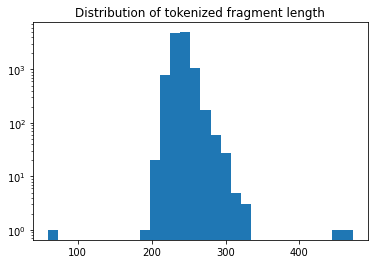

In [25]:
plt.hist([len(sent) for sent in train_tokenized_sample], bins=30)
plt.title('Distribution of tokenized fragment length')
plt.yscale('log');

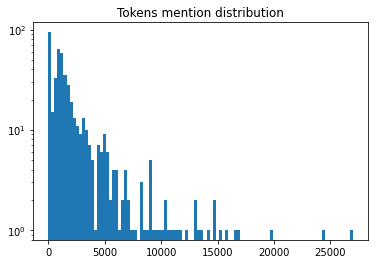

In [26]:
token_counts = np.bincount([token_id for chunk in val_tokenized_sample for token_id in chunk])

plt.hist(token_counts, bins=100)
plt.title('Tokens mention distribution')
plt.yscale('log');

## Creation of [datasets](#scrollTo=OYs7y8NkMDFJ&line=8&uniqifier=1) for PyTorch:

In [27]:
CHUNK_LENGTH = 200

train_dataset = LanguageModelDataset(train_tokenized_sample,
                                     chunk_length=CHUNK_LENGTH)
val_dataset = LanguageModelDataset(val_tokenized_sample,
                                    chunk_length=CHUNK_LENGTH)

## Finding the appropriate batch size for train and validation:

In [28]:
print(f"divisors of train dataset size ({len(train_dataset)}) are {divisors(len(train_dataset))}")
print(f"divisors of val dataset size ({len(val_dataset)}) are {divisors(len(val_dataset))}")

batch_size_train = 66
batch_size_val = 9

divisors of train dataset size (11946) are [1, 2, 3, 6, 11, 22, 33, 66, 181, 362, 543, 1086, 1991, 3982, 5973, 11946]
divisors of val dataset size (5121) are [1, 3, 9, 569, 1707, 5121]


## Using PyTorchEncoderLayer and our [LanguageModel class](#scrollTo=QZBmKyALZ5lq&line=1&uniqifier=1) for model creation:

In [45]:
EMB_SIZE = 300             # if use BPEmb: SUPPORTED_DIMS = [25, 50, 100, 200, 300]
HEADS_NUMBER = 15
DIM_FEEDFORWARD = 500
LAYERS_NUMBER = 8
EMB_DROPOUT = 0.1
LAYER_DROPOUT = 0.1

vectors = BPEmb(language='ru', dim=EMB_SIZE,  merge_ops=min([1000, 3000, 5000, 10000, 25000, 50000, 100000, 200000], key=lambda x:abs(x-tokenizer.vocab_size())))
emb_weights = vectors[tokenizer.vocab()]

TransformerEncoderLayer = nn.TransformerEncoderLayer(d_model=EMB_SIZE, nhead=HEADS_NUMBER, dim_feedforward=DIM_FEEDFORWARD, dropout=LAYER_DROPOUT, activation='gelu')

backbone = BatchFirstTransformerEncoder(TransformerEncoderLayer, num_layers=LAYERS_NUMBER)

torch_transf_model = LanguageModel(vocab_size=tokenizer.vocab_size(), emb_size=EMB_SIZE, backbone=backbone, emb_weights=emb_weights, freeze=False, emb_dropout=EMB_DROPOUT)

print('Number of parameters in model:', get_params_number(torch_transf_model))

Number of parameters in model: 5606100


## [Training](#scrollTo=jx44W288jjRP&line=1&uniqifier=1):

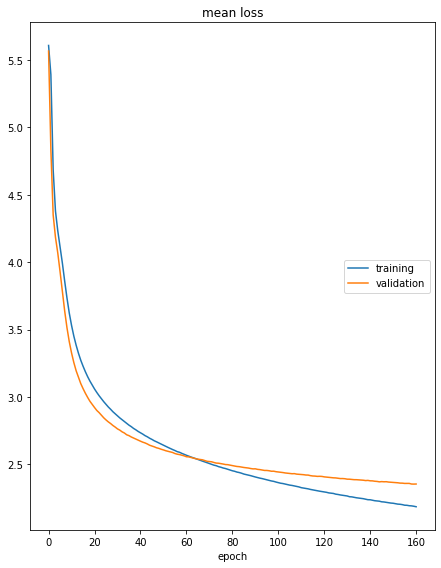

mean loss
	training         	 (min:    2.186, max:    5.608, cur:    2.186)
	validation       	 (min:    2.354, max:    5.566, cur:    2.354)

Stopped early by user


In [46]:
lr_scheduler = lambda optim: \
    torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5, factor=0.75, verbose=True)

#lr_scheduler = lambda optim: \
#    torch.optim.lr_scheduler.StepLR(optim, step_size=5, gamma=0.9)

best_val_loss, best_torch_transf_model = train_eval_loop(torch_transf_model,
                                                         train_dataset,
                                                         val_dataset,
                                                         lm_cross_entropy,
                                                         lr=2e-4,
                                                         epoch_n=300,
                                                         batch_size_train=batch_size_train,
                                                         batch_size_val=batch_size_val,
                                                         device='cuda',
                                                         early_stopping_patience=15,
                                                         lr_scheduler_ctor=lr_scheduler,
                                                         draw_loss=True,
                                                         dataloader_workers_n=5)

In [47]:
MODEL_FILENAME = f"/tmp/best_torch_transf_model_{best_val_loss}.pth"
torch.save(best_torch_transf_model.state_dict(), MODEL_FILENAME)
files.download(MODEL_FILENAME)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Text generation using language modeling:

### Greedy generation:

In [48]:
MAX_STEPS = 100

In [49]:
greedy_generator = GreedyGenerator(best_torch_transf_model, tokenizer)

In [50]:
print(greedy_generator('Многие испытывают то умирание и рождение заново, какое представляет собой наша судьба, ', max_steps_n=MAX_STEPS)) # Демиан

Многие испытывают то умирание и рождение заново, какое представляет собой наша судьба, какое-то время от времени, какое-то время от времени прошлого, какое-то время от времени прошлого, какое-то время от времени, какое-то время от времени прошлого, какое-то время от времени прошлого, какое-то время от времени прошлого, какое-то время от времени прошлого, како


In [51]:
print(greedy_generator('Чрезмерное знание, слишком много священных стихов, слишком много жертвенных правил, ', max_steps_n=MAX_STEPS)) # Сиддхартха

Чрезмерное знание, слишком много священных стихов, слишком много жертвенных правил, слишком много настоящего. Если бы я, наверно, слишком много способности к нему, то я, чтобы он был, чтобы он, слишком много раз, чтобы они были слишком многообещающими. Но, слишком много, слишком много способностей, слишком


In [52]:
print(greedy_generator('В ее глазах, холодных и светлых, витала умудренная грусть, эти глаза, казалось, выстрадали все мыслимые страданья и сказали им «да». ', max_steps_n=MAX_STEPS)) # Степной волк

В ее глазах, холодных и светлых, витала умудренная грусть, эти глаза, казалось, выстрадали все мыслимые страданья и сказали им «да». Любовь к нему я видел, как красивый мужчина, и, подобно тому как он, как я, как он, как всякое время. Если бы я снова и снова увидел, как всякий раз, когда я, снова и снова и снова, снова и снова, снова и с


### Generation using beam search:

In [53]:
beam_generator = BeamGenerator(best_torch_transf_model, tokenizer)

In [54]:
%%time

beam_gen_variants = beam_generator('Многие испытывают то умирание и рождение заново, какое представляет собой наша судьба, ', max_steps_n=MAX_STEPS, beamsize=5, return_hypotheses_n=5)

for score, pred_txt in beam_gen_variants:
    print('****')
    print(score)
    print(pred_txt)
    print()

****
6.8797614035957
Многие испытывают то умирание и рождение заново, какое представляет собой наша судьба, какое-то время от времени, какое-то время от времени прошлого, какое-то время от времени прошлого, какое-то время от времени, каким-то особенно сделалось нечто совсем необыкновенное, что-то от нее и неправильное. Кнехт почувствовал, что-то недо

****
6.894255700261887
Многие испытывают то умирание и рождение заново, какое представляет собой наша судьба, какое-то время от времени, какое-то время от времени прошлого, какое-то время от времени прошлого, какое-то время от времени, каким-то особенно сделалось нечто совсем необыкновенное, что-то от нее и неправильное. Кнехт почувствовал, что-то неи

****
6.909667867544825
Многие испытывают то умирание и рождение заново, какое представляет собой наша судьба, какое-то время от времени, какое-то время от времени прошлого, какое-то время от времени прошлого, какое-то время от времени, каким-то особенно сделалось нечто совсем необыкновенное

In [55]:
%%time

beam_gen_variants = beam_generator('Чрезмерное знание, слишком много священных стихов, слишком много жертвенных правил, ', max_steps_n=MAX_STEPS, beamsize=5, return_hypotheses_n=5)

for score, pred_txt in beam_gen_variants:
    print('****')
    print(score)
    print(pred_txt)
    print()

****
5.232607874028768
Чрезмерное знание, слишком много священных стихов, слишком много жертвенных правил, слишком много напряжений и слишком много нарочито, слишком много способностей, слишком много нарочито, слишком много народов, слишком много народов, слишком много народов, слишком много народов, слишком много насчет то

****
5.254232214295294
Чрезмерное знание, слишком много священных стихов, слишком много жертвенных правил, слишком много напряжений и слишком много нарочито, слишком много способностей, слишком много нарочито, слишком много народов, слишком много народов, слишком много народов, слишком много народов, слишком много насчет и

****
5.258527455031281
Чрезмерное знание, слишком много священных стихов, слишком много жертвенных правил, слишком много напряжений и слишком много нарочито, слишком много способностей, слишком много нарочито, слишком много народов, слишком много народов, слишком много народов, слишком много народов, слишком много насчет г

****
5.28050376974828

In [56]:
%%time

beam_gen_variants = beam_generator('В ее глазах, холодных и светлых, витала умудренная грусть, эти глаза, казалось, выстрадали все мыслимые страданья и сказали им «да». ', max_steps_n=MAX_STEPS, beamsize=5, return_hypotheses_n=5)

for score, pred_txt in beam_gen_variants:
    print('****')
    print(score)
    print(pred_txt)
    print()

****
8.029404517022474
В ее глазах, холодных и светлых, витала умудренная грусть, эти глаза, казалось, выстрадали все мыслимые страданья и сказали им «да». И все-таки этот смерть, казалось, звучалось так же необычно. Лишь смех и смеялся над ней и смотрел на него. — Вот как? — спросил я. — Не знаю, — сказал я. — Я не могу сказать ничего другого. — Нет, ничего.

****
8.084295742987306
В ее глазах, холодных и светлых, витала умудренная грусть, эти глаза, казалось, выстрадали все мыслимые страданья и сказали им «да». И все-таки этот смерть, казалось, звучалось так же необычно. Лишь смех и смеялся над ней и смотрел на него. — Вот как? — спросил я. — Не знаю, — сказал я. — Я не могу сказать ничего другого. — Нет, ничего не

****
8.121333367071816
В ее глазах, холодных и светлых, витала умудренная грусть, эти глаза, казалось, выстрадали все мыслимые страданья и сказали им «да». И все-таки этот смерть, казалось, звучалось так же необычно. Лишь смех и смеялся над ней и смотрел на него. — Вот ка

In [84]:
prob_generator = ProbGenerator(best_torch_transf_model, tokenizer, max_steps_n=MAX_STEPS, temperature=0.75)

In [89]:
print(prob_generator('Многие испытывают то умирание и рождение заново, какое представляет собой наша судьба, '))

Многие испытывают то умирание и рождение заново, какое представляет собой наша судьба, какая-то религия как эта. Вот имеет много неприятных. Согласно знает, что об этом и нет. Всегда именно это я еще стоял как обиду, надо полагать, что способность утонченность и снова принимали письмо читатели при это


In [90]:
print(prob_generator('Чрезмерное знание, слишком много священных стихов, слишком много жертвенных правил, '))

Чрезмерное знание, слишком много священных стихов, слишком много жертвенных правил, слишком много было то, что для него за него ничего не удавалось, слишком много лжи. Старик дружил некоторое время поиски, и, пожалуй, слишком много спрашивал. Он показался мне и вошел в свою комнату. Совершенно мне приходилось стать


In [88]:
print(prob_generator('В ее глазах, холодных и светлых, витала умудренная грусть, эти глаза, казалось, выстрадали все мыслимые страданья и сказали им «да». ')) # Степной волк

В ее глазах, холодных и светлых, витала умудренная грусть, эти глаза, казалось, выстрадали все мыслимые страданья и сказали им «да». Между тем молча вовсе не было колдовством, с которым здесь отдалилась от родины, и на это полуопискалось бы из Провинции и критиковые дела, изменялись, по возможности выдумчиво успеха, и они проглядывали у них в
